# PyGIMLi - DCIP (real dataset)

Using the DCIP (Direct Current, Induced Polarization) solver implemented provided by [PyGIMLi](https://www.pygimli.org/), 
we use different `cofi` solvers to solve problem with a real dataset.

<!--<badge>--><a href="https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/notebooks/pygimli_dcip/pygimli_dcip_century_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

<!-- Again, please don't touch the markdown cell above. We'll generate badge 
     automatically from the above cell. -->

<!-- This cell describes things related to environment setup, so please add more text 
     if something special (not listed below) is needed to run this notebook -->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

Note: This notebook is adapted from a SimPEG example authored by Lindsey Heagy and presented at Transform 2020. [Original Materials](https://curvenote.com/@simpeg/transform-2020-simpeg-tutorial/!6DDumb03Le6D8N8xuJNs)

## 0. Set up environment

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi

# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !mamba install -c gimli pygimli=1.3

We will need the following packages:

- `os` to list and load dataset
- `numpy` for matrices and matrix-related functions
- `matplotlib` for plotting
- `pygimli` for forward modelling of the problem
- `cofi` for accessing different inference solvers

In [29]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pygimli
import cofi

## 1. Load the data

We will need to download the preprocessed dataset first. This notebook [century_data_preprocessing.ipynb](century_data_preprocessing.ipynb) contains the code for data preprocessing.

In [30]:
dc_data = np.loadtxt("century_dc_data.txt")


In [27]:
def load_leapfrog_geologic_section(filename="./century/geologic_section.csv"):
    """
    Load the geologic cross section. 
    """
    fid = open(filename, 'r')
    lines = fid.readlines()
    data = []
    data_tmp = []
    for line in lines[2:]:
        line_data = (line.split(',')[:3])
        if 'End' in line:
            data.append(np.vstack(data_tmp)[:,[0, 2]])
            data_tmp = []
        else:
            data_tmp.append(np.array(line_data, dtype=float))
    return data
geologic_section = load_leapfrog_geologic_section()

In [31]:
a_locs = dc_data[:,0]
b_locs = dc_data[:,1]
m_locs = dc_data[:,2]
n_locs = dc_data[:,3]
dc_obs = dc_data[:,4]
ip_obs = dc_data[:,5]
geo_factors = dc_data[:,6]

In [32]:
location_start = np.min(a_locs)
location_stop = np.max(n_locs)
location_interval = m_locs[1] - m_locs[0]
location_num = int((location_stop - location_start) / location_interval + 1)

location_start, location_stop, location_interval, location_num

(26000.0, 29200.0, 100.0, 33)

## 2. Create a PyGIMLi measuring scheme and fill in the data

In [33]:
data = pygimli.DataContainerERT()

for sensor in np.linspace(location_start, location_stop, location_num):
    data.createSensor((sensor, 0.0, 0.0))

locs_sources = np.vstack((a_locs, b_locs)).T
locs_receivers = np.vstack((m_locs, n_locs)).T
for i in range(len(locs_sources)):
    src = locs_sources[i]
    src_idx = (src - location_start) / location_interval
    rec = locs_receivers[i]
    rec_idx = (rec - location_start) / location_interval
    data.createFourPointData(i, src_idx[0], src_idx[1], rec_idx[0], rec_idx[1])
data

Data: Sensors: 33 data: 151, nonzero entries: ['a', 'b', 'm', 'n', 'valid']

In [34]:
data["rhoa"] = dc_obs
data["k"] = pygimli.physics.ert.createGeometricFactors(data, numerical=True)

11/11/22 - 10:30:25 - pyGIMLi - INFO - Cache /home/jrh/csiro/research/cofi/external/gimli/gimli/pygimli/physics/ert/ert.py:createGeometricFactors restored (2.0s x 1): /home/jrh/.cache/pygimli/2693595932225611764


In [35]:
data

Data: Sensors: 33 data: 151, nonzero entries: ['a', 'b', 'k', 'm', 'n', 'rhoa', 'valid']

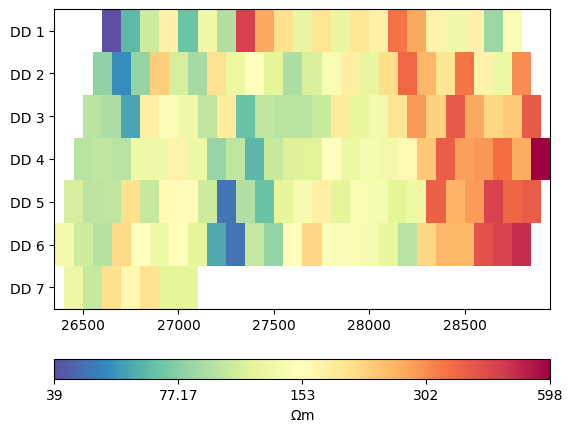

In [36]:
def plot_data(data, data_vals, title):
    fig, ax = plt.subplots(1, 1)
    pygimli.physics.ert.showERTData(
        data, 
        vals=data_vals, 
        label=r"$\Omega$m", 
        ax=ax, 
    )

plot_data(data, data["rhoa"], "test")

## 3. Create inversion mesh

In [37]:
# calculate dimension in x and z directions
n_cells_per_spacing = 4
dx = location_interval / n_cells_per_spacing
dz = dx

# calculate x range
x_range = (location_start, location_stop)

# calculate z range
ab_midpoints = (a_locs + b_locs) / 2
mn_midpoints = (m_locs + n_locs) / 2
ab_mn_separation = np.abs(ab_midpoints - mn_midpoints)
max_separation = np.max(ab_mn_separation)
z_depth = - max_separation / 3.
z_range = (z_depth, 0.)

# print
print(f"Mesh dimension: ({dx}, {dz})")
print(f"Mesh range x: {x_range}")
print(f"Mesh range z: {z_range}")

Mesh dimension: (25.0, 25.0)
Mesh range x: (26000.0, 29200.0)
Mesh range z: (-266.6666666666667, 0.0)


In [38]:
# params for creating mesh nodes
n_midd_extra = 4
n_midd_x = np.ceil(np.diff(x_range)/dx) + n_midd_extra*2
n_top_z = np.ceil(np.diff(z_range)/dz) + n_midd_extra
n_side = 10         # number of nodes extending in x and z
extending_factor = 1.3
extending_list = (np.ones(n_side) * extending_factor) ** (np.arange(n_side) + 1)

# create nodes in x direction
dist_x_left = (extending_list * dx)[::-1]
dist_x_midd = int(n_midd_x) * [dx]
dist_x_right = extending_list * dx
dist_x = np.hstack((dist_x_left, dist_x_midd, dist_x_right))
nodes_x = np.r_[(x_range[1]+x_range[0])/2-np.sum(dist_x)/2, dist_x].cumsum()

# create nodes in z direction
dist_z_bot = (extending_list * dz)[::-1]
dist_z_top = int(n_top_z) * [dz]
dist_z = np.hstack((dist_z_bot, dist_z_top))
nodes_z = np.r_[-np.sum(dist_z), dist_z].cumsum()

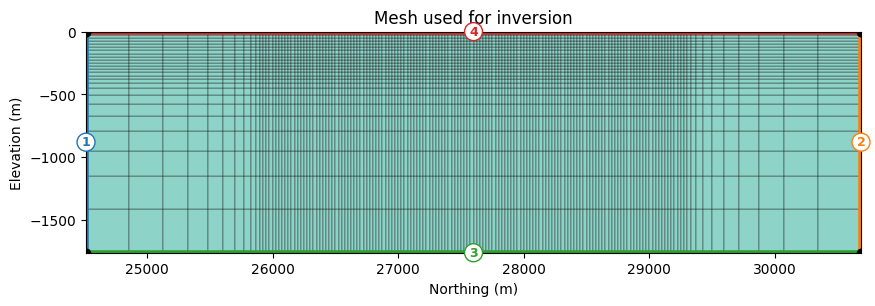

In [39]:
inv_mesh = pygimli.meshtools.createGrid(x=nodes_x, y=nodes_z)

_, ax = plt.subplots(figsize=(10,8))
pygimli.show(inv_mesh, showMesh=True, markers=True, colorBar=False, ax=ax)
ax.set_title("Mesh used for inversion");
ax.set_xlabel("Northing (m)");
ax.set_ylabel("Elevation (m)");

## 4. Set up forward operator and regularization matrix

In [40]:
ert_mgr = pygimli.physics.ert.ERTManager(data)
ert_mgr.setMesh(inv_mesh)

forward_oprt = ert_mgr.fop
forward_oprt.setComplex(False)
forward_oprt.setData(data)
forward_oprt.setMesh(inv_mesh, ignoreRegionManager=True)

region_manager = forward_oprt.regionManager()
region_manager.setConstraintType(2)
Wm = pygimli.matrix.SparseMapMatrix()
region_manager.fillConstraints(Wm)
Wm = pygimli.utils.sparseMatrix2coo(Wm)

11/11/22 - 10:30:39 - pyGIMLi - INFO - Found 1 regions.


In [41]:
start_model = np.ones(inv_mesh.cellCount()) * np.median(data["rhoa"])
start_model_log = np.log(start_model)

11/11/22 - 10:30:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
11/11/22 - 10:30:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


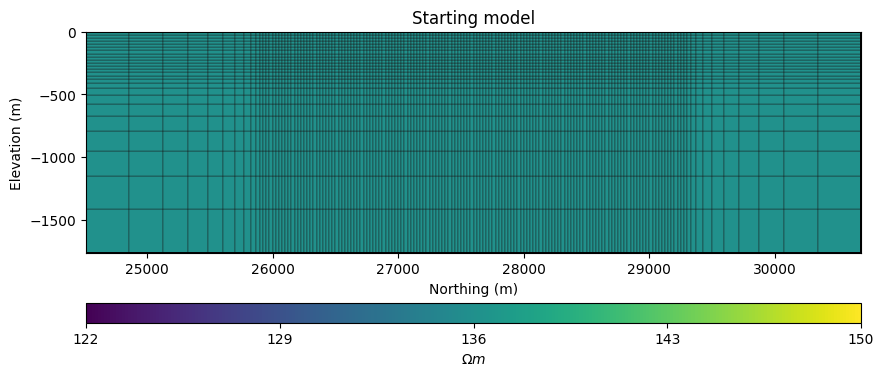

In [42]:
_, ax = plt.subplots(figsize=(10,8))
pygimli.show(ert_mgr.paraDomain, data=start_model, label="$\Omega m$", showMesh=True, ax=ax)
ax.set_title("Starting model")
ax.set_xlabel("Northing (m)");
ax.set_ylabel("Elevation (m)");

## 5. Create utility functions to pass to CoFI

In [43]:
#@title additional utility functions (hidden)
############# Functions provided to CoFI ##############################################

## Note: all functions below assume the model in log space!

def _ensure_numpy(model):
    if "torch.Tensor" in str(type(model)):
        model = model.cpu().detach().numpy()
    return model

def get_response(model, forward_operator):
    # model = _ensure_numpy(model)
    return np.log(np.array(forward_operator.response(np.exp(model))))

def get_residual(model, log_data, forward_operator):
    response = get_response(model, forward_operator)
    residual = log_data - response
    return residual

def get_jacobian(model, forward_operator):
    response = get_response(model, forward_operator)
    model = _ensure_numpy(model)
    forward_operator.createJacobian(np.exp(model))
    J = np.array(forward_operator.jacobian())
    jac = J / np.exp(response[:, np.newaxis]) * np.exp(model)[np.newaxis, :]
    return jac

def get_jac_residual(model, log_data, forward_operator):
    response = get_response(model, forward_operator)
    residual = log_data - response
    model = _ensure_numpy(model)
    forward_operator.createJacobian(np.exp(model))
    J = np.array(forward_operator.jacobian())
    jac = J / np.exp(response[:, np.newaxis]) * np.exp(model)[np.newaxis, :]
    return jac, residual

def get_data_misfit(model, log_data, forward_operator, data_cov_inv=None):
    residual = get_residual(model, log_data, forward_operator)
    data_cov_inv = np.eye(log_data.shape[0]) if data_cov_inv is None else data_cov_inv
    return np.abs(residual.T @ data_cov_inv @ residual)

def get_regularization(model, Wm, lamda):
    model = _ensure_numpy(model)
    model = np.exp(model)
    return lamda * (Wm @ model).T @ (Wm @ model)

def get_objective(model, log_data, forward_operator, Wm, lamda, data_cov_inv=None):
    data_misfit = get_data_misfit(model, log_data, forward_operator, data_cov_inv)
    regularization = get_regularization(model, Wm, lamda)
    obj = data_misfit + regularization
    return obj

def get_gradient(model, log_data, forward_operator, Wm, lamda, data_cov_inv=None):
    jac, residual = get_jac_residual(model, log_data, forward_operator)
    data_cov_inv = np.eye(log_data.shape[0]) if data_cov_inv is None else data_cov_inv
    data_misfit_grad =  - residual.T @ data_cov_inv @ jac
    regularization_grad = lamda * Wm.T @ Wm @ np.exp(model)
    return data_misfit_grad + regularization_grad

def get_hessian(model, log_data, forward_operator, Wm, lamda, data_cov_inv=None):
    jac = get_jacobian(model, forward_operator)
    data_cov_inv = np.eye(log_data.shape[0]) if data_cov_inv is None else data_cov_inv
    hess = jac.T @ data_cov_inv @ jac + lamda * Wm.T @ Wm
    return hess

In [44]:
# test
get_response(start_model_log, forward_oprt)

array([4.89628512, 4.88953445, 4.90223496, 4.8970275 , 4.89057917,
       4.90647465, 4.90263337, 4.89766657, 4.89137344, 4.90924635,
       4.90659707, 4.9029831 , 4.89810104, 4.8920698 , 4.91095433,
       4.90921346, 4.90681378, 4.90321147, 4.89856392, 4.89259538,
       4.91270032, 4.91065279, 4.90935951, 4.90690212, 4.90353531,
       4.89886425, 4.89304137, 4.91038666, 4.91073386, 4.90934151,
       4.90717389, 4.90367656, 4.89913072, 4.89342887, 4.91370001,
       4.91106487, 4.90979516, 4.9072419 , 4.90384471, 4.89939385,
       4.91312597, 4.91155984, 4.90961357, 4.90725377, 4.90397598,
       4.89954263, 4.91601914, 4.9112738 , 4.90964084, 4.90739939,
       4.90409412, 4.8996382 , 4.91086094, 4.91058845, 4.90949629,
       4.90731243, 4.9040015 , 4.89967451, 4.91148964, 4.91107414,
       4.90973829, 4.90736658, 4.90415083, 4.89982804, 4.91325574,
       4.91136165, 4.90964806, 4.90744265, 4.90423534, 4.89982527,
       4.91281037, 4.91077791, 4.909579  , 4.90743727, 4.90414

## 6. Run inversion with CoFI

In [18]:
# hyperparameters
lamda = 0.0001

log_data = np.log(data["rhoa"])

# CoFI - define BaseProblem
ert_problem = cofi.BaseProblem()
ert_problem.name = "Electrical Resistivity Tomography with Century Dataset"
ert_problem.set_forward(get_response, args=[forward_oprt])
ert_problem.set_jacobian(get_jacobian, args=[forward_oprt])
ert_problem.set_residual(get_residual, args=[log_data, forward_oprt])
ert_problem.set_data_misfit(get_data_misfit, args=[log_data, forward_oprt])
ert_problem.set_regularization(get_regularization, args=[Wm, lamda])
ert_problem.set_gradient(get_gradient, args=[log_data, forward_oprt, Wm, lamda])
ert_problem.set_hessian(get_hessian, args=[log_data, forward_oprt, Wm, lamda])
ert_problem.set_initial_model(start_model_log)

In [19]:
# test
ert_problem.data_misfit(start_model_log), ert_problem.regularization(start_model_log)

(42.79633333409518, 7.148973067474899e-29)

In [20]:
# CoFI - define InversionOptions
inv_options = cofi.InversionOptions()
inv_options.set_tool("cofi.simple_newton")
inv_options.set_params(max_iterations=10, step_length=0.01)

# CoFI - define Inversion and run
inv = cofi.Inversion(ert_problem, inv_options)
inv_result = inv.run()

print(f"\nNumber of objective function evaluations: {inv_result.n_obj_evaluations}")
print(f"Number of gradient function evaluations: {inv_result.n_grad_evaluations}")
print(f"Number of hessian function evaluations: {inv_result.n_hess_evaluations}")

Iteration #0, objective function value: 42.79633333409518
Iteration #1, objective function value: 41.98196892837691
Iteration #2, objective function value: 41.22422465847311
Iteration #3, objective function value: 40.51928421485763
Iteration #4, objective function value: 39.86313776726735
Iteration #5, objective function value: 39.25271741675118
Iteration #6, objective function value: 38.68526815757375
Iteration #7, objective function value: 38.1583584493509
Iteration #8, objective function value: 37.66980243918946
Iteration #9, objective function value: 37.217608077582454

Number of objective function evaluations: 10
Number of gradient function evaluations: 10
Number of hessian function evaluations: 10


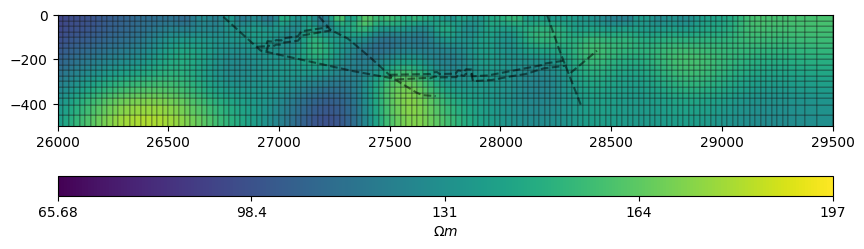

In [28]:
_, ax = plt.subplots(figsize=(10,8))
pygimli.show(ert_mgr.paraDomain, data=np.exp(inv_result.model), label="$\Omega m$", showMesh=True, ax=ax)
ax.set_xlim([26000,29500])
ax.set_ylim([-500,0])

for data in geologic_section:
    ax.plot(data[:,0], data[:,1], 'k--', alpha=0.5)